In [86]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path

# Helper functions
# from helper_functions import imgs_to_numpy

# Styles for miles
style.use('ggplot')

In [60]:
model_deepfake = keras.Sequential([
  keras.Input(shape = (256, 256, 3)),
  #layers.experimental.preprocessing.Normalization(axis = -1, variance = 255*255),  #FIXME - THis line
  layers.Conv2D(filters = 64, kernel_size = 4, strides = (1, 1), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D((4, 4)),
  layers.Conv2D(filters = 32, kernel_size = 4, strides = (1, 1), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D((4, 4)),
  layers.Conv2D(filters = 16, kernel_size = 4, strides = (1, 1), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D((4, 4)),
  layers.Flatten(),
  layers.Dense(units = 4096, activation = 'relu'),
  layers.Dropout(rate = 0.1),
  layers.Dense(units = 256, activation = 'relu'), 
  layers.Dense(units = 1, activation = 'softmax')
])

In [64]:
model_deepfake.compile(optimizer = SGD(lr=1e-6), 
                       metrics = [keras.metrics.BinaryAccuracy(), 
                                  keras.metrics.Precision(), 
                                  keras.metrics.Recall()],
                       loss = keras.losses.BinaryCrossentropy())

In [65]:
model_deepfake.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 256, 256, 64)      3136      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        32800     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 16)        8208      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)              

In [61]:
DATADIR = Path('data/') / 'real_vs_fake' / 'real-vs-fake'
DATADIR

PosixPath('data/real_vs_fake/real-vs-fake')

In [93]:
def GimmeImages(data_split, batch_size = 100):
    DATADIR = Path('data/') / 'real_vs_fake' / 'real-vs-fake' / data_split
    imgs = DirectoryIterator(DATADIR,
                             image_data_generator = ImageDataGenerator(rescale = 1./255),
                             color_mode = 'rgb', 
                             classes = ["real", "fake"],
                             target_size = (256, 256),
                             batch_size = batch_size,
                             class_mode = 'binary',
                             shuffle = True)
    return imgs

In [91]:
train_imgs = GimmeImages('train')
val_imgs   = GimmeImages('valid')
test_imgs  = GimmeImages('test')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [78]:
train_imgs.class_indices

{'real': 0, 'fake': 1}

In [94]:
model_fit = model_deepfake.fit(train_imgs,
                               epochs = 1,
                               validation_data = val_imgs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1000 steps, validate for 200 steps
 306/1000 [========>.....................] - ETA: 2:50 - loss: 7.6306 - binary_accuracy: 0.4996 - precision_7: 0.4996 - recall_7: 1.0000

KeyboardInterrupt: 

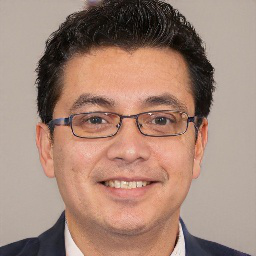

In [45]:
tf.keras.preprocessing.image.load_img(path='data/real_vs_fake/real-vs-fake/train/fake/00A0WLZE5X.jpg', grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest')

In [14]:
tf.keras.preprocessing.image_dataset_from_directory(
    directory="data",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

AttributeError: module 'tensorflow_core.keras.preprocessing' has no attribute 'image_dataset_from_directory'

In [ ]:
# Save images as numpy array
for dsplit in ('train', 'valid', 'test'):
    imgs_to_numpy(dsplit=dsplit)

In [ ]:
# df['path'].tail()
img_path = 'train/fake/73ILM40K3Z.jpg'
img_idx = 99999
img = plt.imread(DATADIR / img_path)
X[img_idx, :, :, :] = img / 255.0

In [34]:
dsplit = 'train'

# Check that the split exists
if dsplit not in ('train', 'valid', 'test'):
    raise Exception('dsplit must be `train`, `test`, or `valid`')

# Load labeled dataframes
PATHDIR = Path('data')
DATADIR = Path('data/') / 'real_vs_fake' / 'real-vs-fake'
SAVEPATH = PATHDIR / 'data_array'

df = pd.read_csv(PATHDIR / f'{dsplit}.csv', header=0).drop(
    ['original_path', 'Unnamed: 0', 'label_str'], axis=1)

# Create containers for the image data
n = df.shape[0]
X = np.empty(shape=(n, 256, 256, 3))
y = df['label'].to_numpy()[np.newaxis].reshape(-1, 1)

In [ ]:
# X[img_idx, :, :, :]
with open(SAVEPATH / f'X_{dsplit}.npy', 'wb') as file:
    np.save(file, X)

In [ ]:
with open(SAVEPATH / f'y_{dsplit}.npy', 'wb') as file:
        np.save(file, y)

In [ ]:
X = np.random.randn(n, 256, 256, 3)

In [ ]:
# Load in the training data
PATHTRAIN = Path('data') / 'data_array'
with tf.device('/device:GPU:0'):
    with open(PATHTRAIN / 'X_train.npy', 'rb') as f:
        X = np.load(f)
    
    with open(PATHTRAIN / 'y_train.npy', 'rb') as f:
        y = np.load(f)
print(X.shape)
print(y.shape)

In [ ]:
model_fit.history['binary_accuracy']

In [ ]:
plt.plot(model_fit.history['binary_accuracy'], 'g.-', label = 'Binary Accuracy')
plt.plot(model_fit.history['val_binary_accuracy'], 'r.-', label = 'Val Binary Accuracy')
plt.legend()
plt.title('Binary Accuracy over Time')
plt.show()

In [ ]:
plt.plot(model_fit.history['precision'], 'g.-', label = 'Precision')
plt.plot(model_fit.history['val_precision'], 'r.-', label = 'Val Precision')
plt.legend()
plt.title('Precision over Time')
plt.show()